In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score

data_dir = Path("~/Desktop/MINES/COGCC-Risk-Analysis/Data").expanduser()

# Load the *same* split the R code uses
train_df = pd.read_csv(data_dir / "train_data_split.csv")
test_df  = pd.read_csv(data_dir / "test_data_split.csv")
  
# Sanity check
print(train_df.shape, test_df.shape)
print(train_df['risk'].value_counts(normalize=True))
print(test_df['risk'].value_counts(normalize=True))

(925, 14) (395, 14)
risk
0    0.949189
1    0.050811
Name: proportion, dtype: float64
risk
0    0.951899
1    0.048101
Name: proportion, dtype: float64


In [2]:
# Drop the response before encoding
X_train_raw = train_df.drop(columns=["risk"])
X_test_raw  = test_df.drop(columns=["risk"])

# One-hot encode EVERYTHING (like dummyVars(risk ~ ., ...))
# drop_first=True ~ fullRank = TRUE (no redundant dummy)
X_train = pd.get_dummies(X_train_raw, drop_first=True)
X_test  = pd.get_dummies(X_test_raw, drop_first=True)

# Make sure train/test have identical columns
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Response vectors
y_train = train_df["risk"].values
y_test  = test_df["risk"].values

Z_train = X_train[["fluid_Other", "elevation"]].copy()
Z_test  = X_test[["fluid_Other", "elevation"]].copy()

train_sel = pd.concat(
    [pd.Series(y_train, name="risk"), Z_train.reset_index(drop=True)], axis=1
)
test_sel = pd.concat(
    [pd.Series(y_test, name="risk"), Z_test.reset_index(drop=True)], axis=1
)

In [ ]:
# Scale features (like before)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(Z_train)
X_test_scaled  = scaler.transform(Z_test)

# Define classifiers (with probability=True for SVC so we can get probs)
classifiers = {
    "Logistic": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(kernel="rbf", C=1.0, probability=True),
    "GradBoost": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm="SAMME"),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
}

EPS = 1e-15

def brier_score(y, p):
    p = np.clip(p, EPS, 1 - EPS)
    return np.mean((y - p) ** 2)

def loglik_binom(y, p):
    p = np.clip(p, EPS, 1 - EPS)
    return np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

def threshold_sweep_f1(y_true, p_pred, thresholds=None):
    """
    Sweep thresholds, compute F1, return best F1 and the threshold that achieves it.
    This mirrors your R threshold loop, just focusing on F1.
    """
    if thresholds is None:
        thresholds = np.arange(0.01, 0.51, 0.01)

    best_f1 = -1.0
    best_thresh = None

    for t in thresholds:
        y_hat = (p_pred > t).astype(int)
        f1 = f1_score(y_true, y_hat, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    return best_f1, best_thresh

# ---------------------------------------------------------
# Core pipeline: run models under regular / PCA / CCA
# ---------------------------------------------------------
def run_model_family(modeling_type, classifiers, Z_train, Z_test, y_train, y_test,
                     pca_n_components=2, cca_n_components=1):
    """
    modeling_type: 'regular', 'pca', or 'cca'
    Returns:
      - metrics_df: one row per classifier with loglik, Brier, best_F1, best_thresh
      - preds_df: per-observation predicted probabilities for each classifier
    """

    # Transform features depending on modeling_type
    if modeling_type == "regular":
        Xtr = Z_train
        Xte = Z_test

    elif modeling_type == "pca":
        pca = PCA(n_components=pca_n_components)
        Xtr = pca.fit_transform(Z_train)
        Xte = pca.transform(Z_test)

    elif modeling_type == "cca":
        cca = CCA(n_components=cca_n_components)
        # CCA requires y to be 2D; y is binary {0,1}
        y_train_2d = y_train.reshape(-1, 1)
        y_test_2d  = y_test.reshape(-1, 1)
        Xtr, _ = cca.fit_transform(Z_train, y_train_2d)
        Xte, _ = cca.transform(Z_test, y_test_2d)

    else:
        raise ValueError("Unknown modeling_type; choose 'regular', 'pca', or 'cca'.")

    rows = []
    preds_dict = {}

    for name, clf in classifiers.items():
        label = f"{name}_{modeling_type}"

        print(f"\n=== {label} ===")

        # Fit classifier on transformed features
        clf.fit(Xtr, y_train)

        # Predicted probabilities for class 1
        if hasattr(clf, "predict_proba"):
            p_test = clf.predict_proba(Xte)[:, 1]
        else:
            # Fallback: use decision_function + logistic squash if no predict_proba
            # (but with this classifier set, we should always have predict_proba)
            scores = clf.decision_function(Xte)
            p_test = 1 / (1 + np.exp(-scores))

        # Metrics mirroring R code
        loglik = loglik_binom(y_test, p_test)
        brier  = brier_score(y_test, p_test)
        best_f1, best_thresh = threshold_sweep_f1(y_test, p_test)

        print(f"Log-likelihood (test): {loglik:.3f}")
        print(f"Brier score (test)   : {brier:.4f}")
        print(f"Best F1              : {best_f1:.4f} at threshold {best_thresh:.2f}")

        rows.append({
            "modeling_type": modeling_type,
            "model": name,
            "label": label,
            "loglik": loglik,
            "brier": brier,
            "best_F1": best_f1,
            "best_thresh": best_thresh,
        })

        preds_dict[label] = p_test

    metrics_df = pd.DataFrame(rows)
    preds_df = pd.DataFrame(preds_dict, index=Z_test.index)

    return metrics_df, preds_df

# ---------------------------------------------------------
# Run all three modeling types
# ---------------------------------------------------------
metrics_reg, preds_reg = run_model_family(
    "regular", classifiers, Z_train, Z_test, y_train, y_test
)

metrics_pca, preds_pca = run_model_family(
    "pca", classifiers, Z_train, Z_test, y_train, y_test,
    pca_n_components=2  # or whatever you used before
)

metrics_cca, preds_cca = run_model_family(
    "cca", classifiers, Z_train, Z_test, y_train, y_test,
    cca_n_components=1
)

# Combine metric tables
metrics_all = pd.concat([metrics_reg, metrics_pca, metrics_cca], ignore_index=True)
print("\n====================")
print("Summary of all models:")
print("====================")
print(metrics_all.sort_values("best_F1", ascending=False))

# ---------------------------------------------------------
# If you want per-observation predictions in a standardized CSV
# (model, idx, lon, lat, risk, pred) like R:
# ---------------------------------------------------------

# Stack all predictions horizontally
all_ml_preds = pd.concat([preds_reg, preds_pca, preds_cca], axis=1)

# Example: pick one model, e.g. best by F1:
best_label = metrics_all.sort_values("best_F1", ascending=False)["label"].iloc[0]
print(f"\nBest overall ML model (by F1): {best_label}")

# Build standardized table for that model
best_pred = all_ml_preds[best_label].values
ml_pred_table = pd.DataFrame({
    "model": best_label,
    "idx": np.arange(1, len(y_test) + 1),
    "lon": test_df.loc[all_ml_preds.index, "lon"].values,
    "lat": test_df.loc[all_ml_preds.index, "lat"].values,
    "risk": y_test.astype(int),
    "pred": best_pred,
})

ml_pred_table.to_csv(data_dir / "predictions_best_ml_model.csv", index=False)
print("Saved best ML model predictions to predictions_best_ml_model.csv")



=== Logistic_regular ===
Log-likelihood (test): -66.581
Brier score (test)   : 0.0411
Best F1              : 0.4242 at threshold 0.15

=== KNN_regular ===
Log-likelihood (test): -342.503
Brier score (test)   : 0.0474
Best F1              : 0.2222 at threshold 0.01

=== SVM_regular ===
Log-likelihood (test): -100.574
Brier score (test)   : 0.0489
Best F1              : 0.0729 at threshold 0.08

=== GradBoost_regular ===
Log-likelihood (test): -77.187
Brier score (test)   : 0.0502
Best F1              : 0.2951 at threshold 0.05

=== AdaBoost_regular ===
Log-likelihood (test): -178.032
Brier score (test)   : 0.1339
Best F1              : 0.3913 at threshold 0.41

=== RandomForest_regular ===
Log-likelihood (test): -325.299
Brier score (test)   : 0.0598
Best F1              : 0.2909 at threshold 0.09

=== Logistic_pca ===
Log-likelihood (test): -66.581
Brier score (test)   : 0.0411
Best F1              : 0.4242 at threshold 0.15

=== KNN_pca ===
Log-likelihood (test): -342.503
Brier score

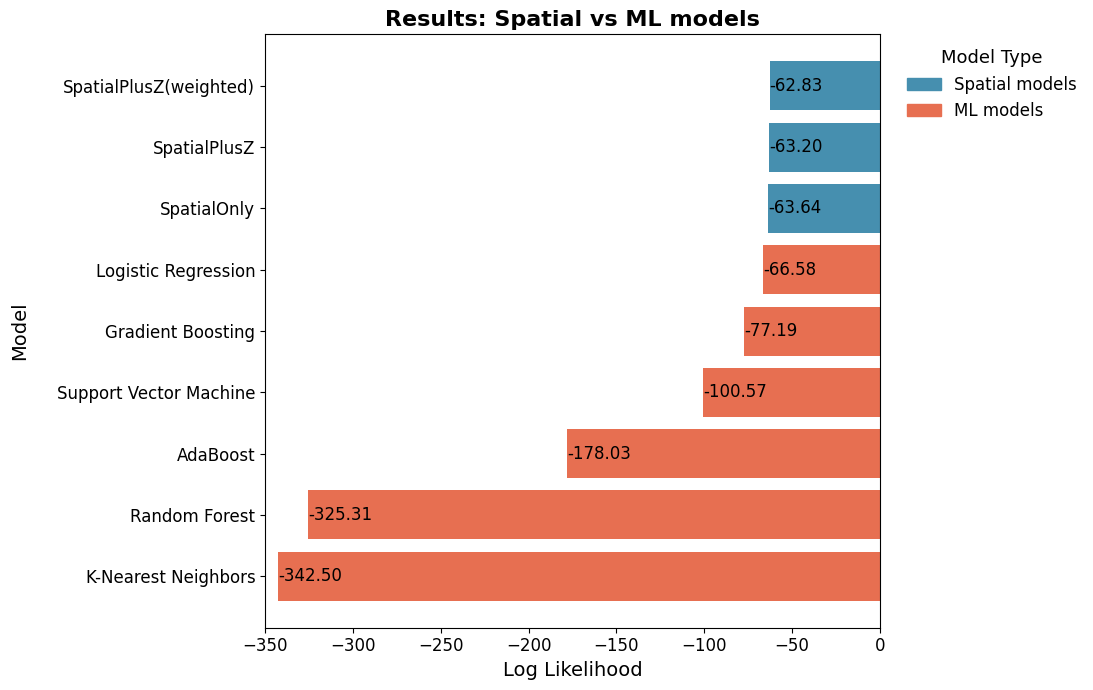

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

# Example F1 scores
f1_data = {
    "model": ["GLM", "SpatialOnly", "SpatialPlusZ", "SpatialPlusZ(weighted)",
              "Logistic Regression", "K-Nearest Neighbors", "Support Vector Machine",
              "Gradient Boosting", "AdaBoost", "Random Forest"],
    "Log_likelihood": [-66.48, -63.64, -63.20, -62.83, 
                       -66.581, -342.503, -100.574,
                       -77.187, -178.032, -325.305],
    "source": ["GLM", "SpatialOnly", "SpatialPlusZ", "SpatialPlusZ(weighted)",
               "Sklearn_Regular","Sklearn_Regular","Sklearn_Regular",
               "Sklearn_Regular","Sklearn_Regular","Sklearn_Regular"]
}
df_f1 = pd.DataFrame(f1_data)

# Drop GLM
df_f1 = df_f1[df_f1["model"] != "GLM"]

# Assign groups
SPATIAL = {"SpatialOnly", "SpatialPlusZ", "SpatialPlusZ(weighted)"}
df_f1["Group"] = df_f1["model"].apply(lambda m: "Spatial models" if m in SPATIAL else "ML models")

# Sort ascending
df_f1 = df_f1.sort_values("Log_likelihood", ascending=True)
# Colors
group_colors = {"Spatial models": "#468faf", "ML models": "#e76f51"}
colors = df_f1["Group"].map(group_colors)

# Plot
plt.figure(figsize=(9,7))
plt.barh(df_f1["model"], df_f1["Log_likelihood"], color=colors)

# Annotate bars with two decimals
for i, v in enumerate(df_f1["Log_likelihood"]):
    plt.text(v+0.01, i, f"{v:.2f}", va="center", fontsize=12)  # bigger numbers

# Reference baseline
plt.axvline(0.5, color="gray", linestyle="--", linewidth=1)

# Axis labels + title
plt.xlabel("Log Likelihood", fontsize=14)
plt.ylabel("Model", fontsize=14, labelpad=20)  # move it left with labelpad
plt.title("Results: Spatial vs ML models", fontsize=16, weight="bold")

# Tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.xlim(-350, 0)

# Legend outside right
handles = [Patch(color=col, label=grp) for grp, col in group_colors.items()]
plt.legend(handles=handles, title="Model Type",
           title_fontsize=13, fontsize=12,   # bigger legend
           loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)

plt.show()